You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch 
[
N
×
N
]
 into two smaller matrices of size 
[
N
×
r
]
 and 
[
r
×
N
]
 using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

Test different values for the low-rank 
r
=
[
5
,
10
,
25
,
50
]
.
Use Gradient Descent to learn the compressed matrices.
Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
Compute the RMSE and PSNR for each value of 
r
.

In [30]:
# -*- important imports-*-
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
import matplotlib.pyplot as plt
from einops import rearrange
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
import matplotlib.patches as patches

dog.jpg exists
torch.Size([3, 1365, 2048])


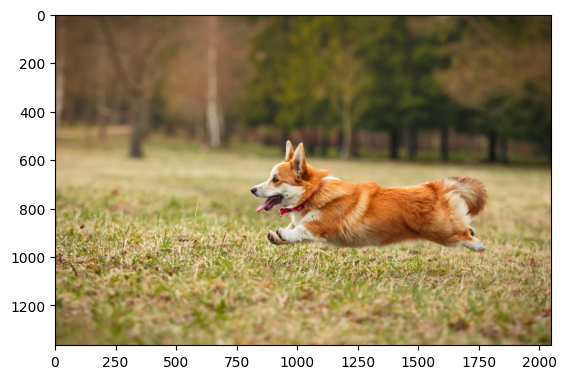

In [31]:

if os.path.exists("dog.jpg"):
    print('dog.jpg exists')
else:    
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Load the image
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
plt.imshow(rearrange(img,'c h w -> h w c'));
    

Original image shape: torch.Size([3, 1365, 2048])
Cropped image shape: torch.Size([3, 300, 300])


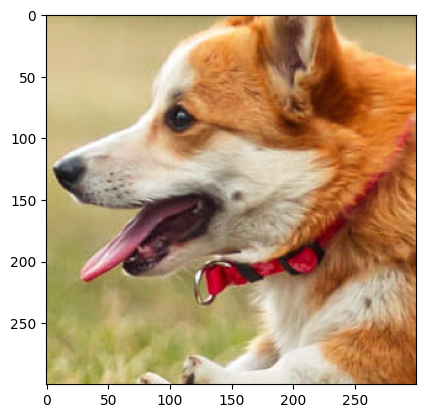

In [32]:

# Scale the image pixel values between 0 and 1 using MinMaxScaler
scaler_img=preprocessing.MinMaxScaler().fit(img.reshape(-1,1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled).to(device)
print(f"Original image shape: {img.shape}")
# Crop a specific region of size (300, 300) from the top-left corner (600, 800) of the scaled image
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
# Display the cropped image
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
print(f"Cropped image shape: {crop.shape}")

In [33]:
#function to extract a patch from an image
def get_patch(image,patch_size,x_min,y_min):
    """
    Extract a patch from an image given the top-left corner coordinates and the patch size.
    Args:
    image (Tensor): The input image.
    patch_size (int): The size of the patch.
    x_min (int): The x-coordinate of the top-left corner of the patch.
    y_min (int): The y-coordinate of the top-left corner of the patch.
    Returns:
    Tensor: The extracted patch.
    """
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]  

In [34]:
image=crop
image_shape = (3, 300, 300)
patch_size = 50
min_x = 0
max_x = image.shape[2] - patch_size
min_y = 0
max_y = image.shape[1] - patch_size
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


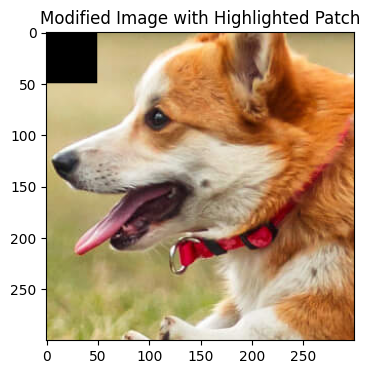

In [35]:
# Updated function to plot the image with the patch and return the modified image as a tensor
def plot_image_with_patch(image, patch_size, x, y, ax, highlight_color="red", mask_color="gray"):
    image_np = rearrange(image, 'c h w -> h w c').cpu().numpy()
    ax.imshow(image_np)

    # Apply the rectangle patch to the image
    image_with_patch = image.clone().detach()
    image_with_patch[:, y:y + patch_size, x:x + patch_size] = 0  # Modify based on your requirement

    return image_with_patch

# Example usage
patch_size = 50
x, y = 0, 0  # Set the coordinates of the patch
image = crop  # Assuming 'crop' is the original image tensor

# Create a single subplot for the original or modified image
fig, ax = plt.subplots(figsize=(8, 4))

# Call the function to plot the image with the highlighted patch and get the modified image as a tensor
single_image = plot_image_with_patch(image, patch_size, x, y, ax)

# Convert the modified image tensor to a NumPy array for visualization
single_image_np = rearrange(single_image, 'c h w -> h w c').cpu().numpy()
plt.imshow(single_image_np)
plt.title("Modified Image with Highlighted Patch")
plt.show()
# single_image.shape

In [36]:
single_image.shape[1]

300

In [41]:
def plot_original_masked_reconstructed_images(original, masked, reconstructed, title1, title2, title3):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original image
    original_image =original.clone()
    original_image=rearrange(original_image,'c h w -> h w c') 
    axs[0].imshow(original_image.cpu().numpy())
    axs[0].set_title(title1)
    
    # Plot masked image
    masked_image =masked.clone()
    masked_image=rearrange(masked_image,'c h w -> h w c')
    axs[1].imshow(masked_image.cpu().numpy())
    axs[1].set_title(title2)
    
    # Replace the patch with the reconstructed patch in the masked image
    reconstructed_patch = reconstructed[y:y+patch_size, x:x+patch_size, :].detach().cpu().numpy()    
    plt.imshow(reconstructed_patch)
    img=reconstructed[y:y+patch_size, x:x+patch_size, :]
    print(img.shape)
    masked_patch_reconstructed = masked_image.clone().detach().cpu().numpy()
    masked_patch_reconstructed[y:y+patch_size, x:x+patch_size, :]=reconstructed_patch
    axs[2].imshow(masked_patch_reconstructed)
    axs[2].set_title(title3)
    
    plt.show()

In [42]:
import math

def compute_rmse(original_image, reconstructed_image):
    """
    Computes the Root Mean Squared Error (RMSE) between the original and reconstructed images.
    Assumes images are of shape [C, H, W] (channels, height, width).
    """
    mse = torch.mean((original_image - reconstructed_image) ** 2)  # Mean Squared Error
    rmse = torch.sqrt(mse)  # Root Mean Squared Error
    return rmse.item()

def compute_psnr(original_image, reconstructed_image, max_pixel_value=1.0):
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    """
    rmse = compute_rmse(original_image, reconstructed_image)
    if rmse == 0:  # Prevent division by zero
        return float('inf')
    
    psnr = 20 * math.log10(max_pixel_value / rmse)  # Compute PSNR
    return psnr

torch.Size([3, 300, 300])
Iteration 0, Loss: 2066.233607676404
Rank: 5, RMSE: 0.4936, PSNR: 6.13 dB
torch.Size([50, 50, 3])


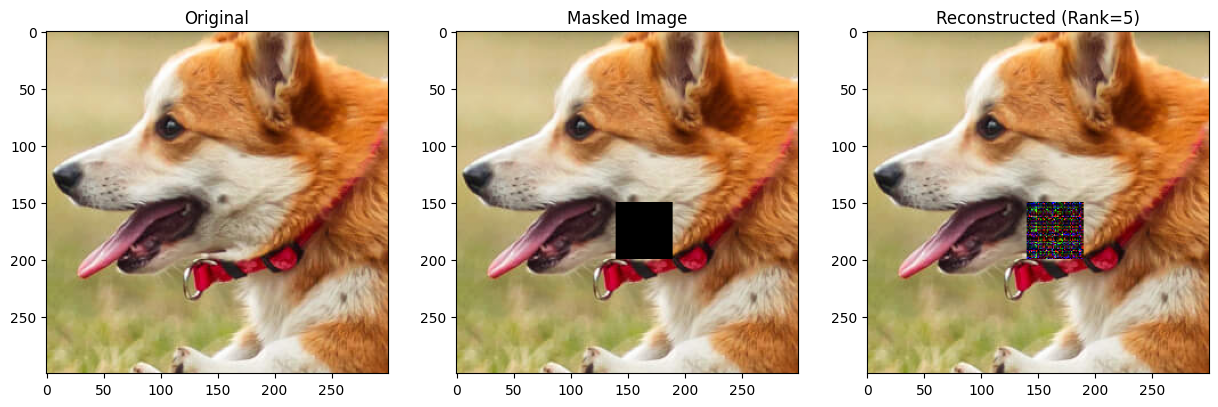

Iteration 0, Loss: 2909.2063239506315
Rank: 10, RMSE: 0.4612, PSNR: 6.72 dB
torch.Size([50, 50, 3])


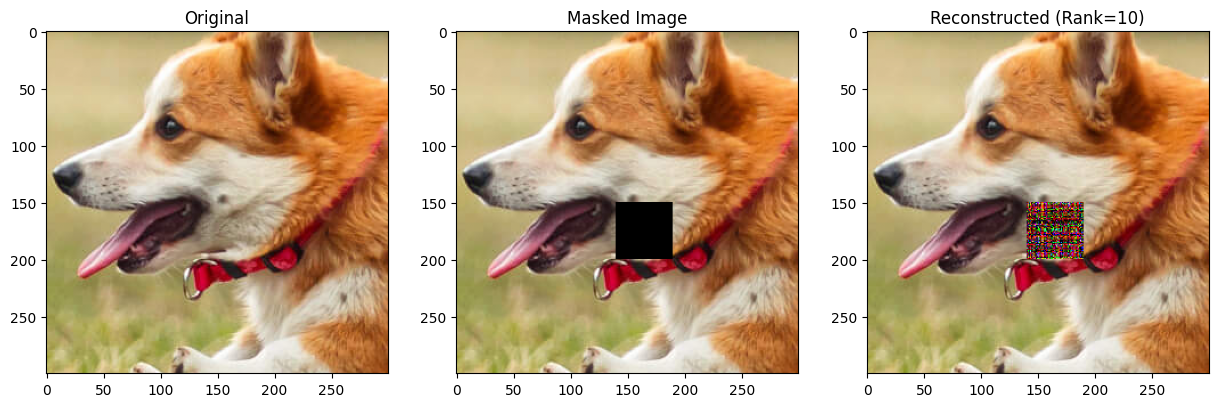

Iteration 0, Loss: 4543.434332274183
Rank: 25, RMSE: 0.4481, PSNR: 6.97 dB
torch.Size([50, 50, 3])


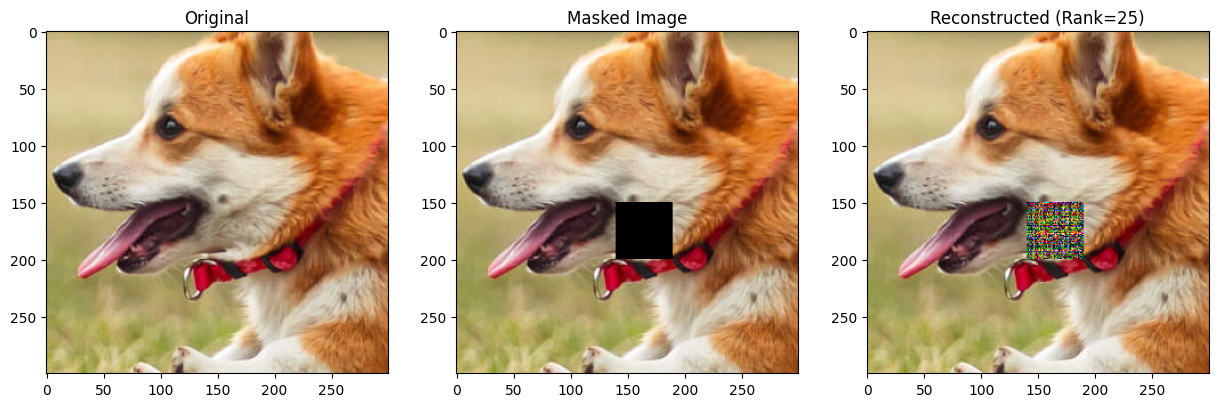

Iteration 0, Loss: 6402.808630344653
Rank: 50, RMSE: 0.4117, PSNR: 7.71 dB
torch.Size([50, 50, 3])


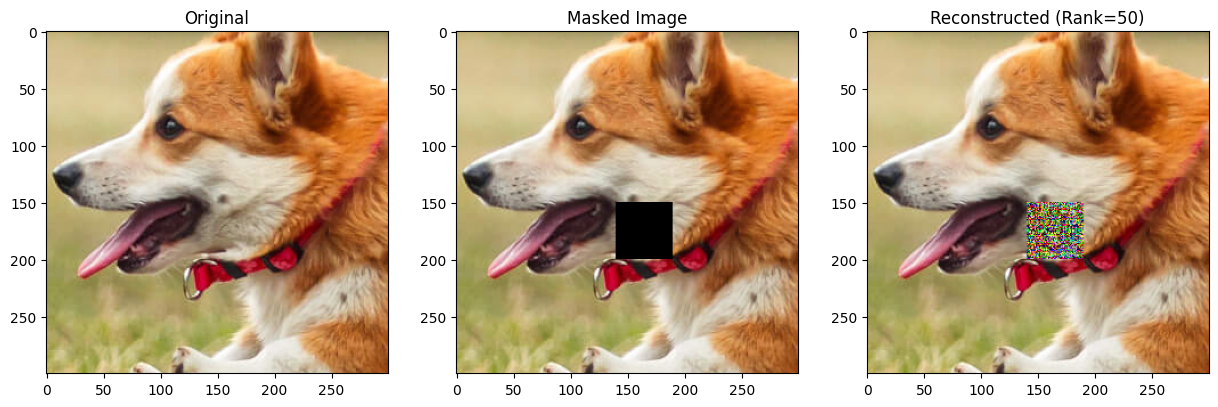

In [44]:
patch_size = 50
x, y = 140, 150  
image = crop  
print(image.shape)
# Plot the original image with a patch
cropped_image = plot_image_with_patch(image, patch_size, x, y, ax)
cropped_image = cropped_image.to(device)
image=image.to(device)
r_values = [5, 10, 25, 50] 
num_iterations = 101
learning_rate = 0.01

# Iterate over different low-rank values
for rank in r_values:
    Ws = []
    Hs = []

    # Initialize W and H matrices separately for each channel
    for channel in range(cropped_image.shape[0]):
        W = torch.randn(cropped_image.shape[1], rank, requires_grad=True, device=device)
        H = torch.randn(rank, cropped_image.shape[2], requires_grad=True, device=device)
        Ws.append(W)
        Hs.append(H)

    # Optimizer and training loop
    optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
    for iteration in range(num_iterations):
        losses = []

        # Calculate loss for each channel
        for channel in range(cropped_image.shape[0]):
            loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - image[channel, :, :], p="fro")
            losses.append(loss)

        total_loss = sum(losses)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if iteration % 200 == 0:
            print(f"Iteration {iteration}, Loss: {total_loss.item()}")

    # Reconstruct the image with 3 channels
    reconstructed_channels = [torch.mm(Ws[channel], Hs[channel]) for channel in range(cropped_image.shape[0])]
    reconstructed_image = torch.stack(reconstructed_channels, dim=0)  # Combine channels
    reconstructed_image = rearrange(reconstructed_image, 'c h w -> h w c')
    reconstructed_image = torch.clamp(reconstructed_image, 0, 1)
    # Calculate RMSE and PSNR
    reconstructed_image_rearranged = rearrange(reconstructed_image, 'h w c -> c h w')
    rmse_value = compute_rmse(cropped_image, reconstructed_image_rearranged)
    psnr_value = compute_psnr(cropped_image, reconstructed_image_rearranged, max_pixel_value=1.0)

    print(f"Rank: {rank}, RMSE: {rmse_value:.4f}, PSNR: {psnr_value:.2f} dB")
    # Plot the original, masked, and reconstructed images
    plot_original_masked_reconstructed_images(crop, cropped_image, reconstructed_image,
                                              title1="Original", title2="Masked Image", title3=f"Reconstructed (Rank={rank})")